# **Balanced Risk Set Matching**


- **Ladrera**, Raiken  
- **Tibon**, Hestia  

---
--


### **Objective:**

Imagine you have two groups of people in a study, to compare two groups of patients, one that received treatment and one that did not, while ensuring they are similar in key aspects. This allows researchers to determine whether the treatment is truly effective or if any differences are merely due to chance.


**Balanced Risk Set Matching (BRSM)** is an effective method to address this issue. Rather than randomly selecting individuals from both groups, it carefully matches individuals who are as similar as possible, except for whether they received the treatment. This ensures that both groups share the same distribution of key characteristics, such as age, health, and income.


### <b> How does it work?

**- Identify Similar Patients:** When a patient receives treatment, we find another patient with similar symptoms who has not yet undergone treatment.  
**- Ensure Balanced Groups:** We ensure both groups have a well-distributed mix of symptoms for a fair comparison.  
**- Track Changes Over Time:** We monitor symptom progression after treatment and compare outcomes between the two groups.  
**- Apply Mathematical Fairness:** Integer programming is used to ensure an unbiased and accurate matching process.
cess.
ss.

### **Data Used:**

Patient records with:
- Symptoms before treatment (*pain, urgency, frequency*).
- Treatment time (*if they received treatment*).
- Post-treatment symptoms (*after a simulated effect of treatment*).
).
  
t).

### **Packages and Libraries**

In [3]:
# Required Packages
!pip install numpy pandas scipy matplotlib seaborn

# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon
from collections import defaultdict

### **Global Variables**

In [21]:
np.random.seed(25)

# Number of patients and evaluation periods
number_of_patients = 210
evaluation_years = 4
evaluation_months = evaluation_years * 12
MAX_MATCHES = 100

BOX_TITLES = [
    'Baseline',
    'At Treatment',
    '3 Months after Treatment',
    '6 Months after Treatment',
    'Difference (3 mos posttreatment)',
    'Difference (6 mos posttreatment)'
]

BOX_LABELS = ['Untreated', 'Treated']

### **Data Preparation**

In [22]:
# Synthetic baseline data for patients
baseline_data = pd.DataFrame({
    "patient_id": np.arange(0, number_of_patients),
    "gender": np.random.choice(['M', 'F'], number_of_patients),
    "pain": np.random.randint(0, 10, number_of_patients),
    "urgency": np.random.randint(0, 10, number_of_patients),
    "frequency": np.random.randint(0, 20, number_of_patients)
})

baseline_data.head()

,patient_id,gender,pain,urgency,frequency
0,0,M,5,4,10
1,1,M,6,0,18
2,2,M,9,3,16
3,3,F,8,9,6
4,4,F,6,0,19


### **Evaluation Data**

In [23]:
# Synthetic evaluation data for patients at 3-month intervals
evaluation_data = pd.DataFrame()

for patient_id in range(number_of_patients):
    chosen_treatment_time = np.random.choice(list(np.arange(3, evaluation_months + 1, 3)) + [None])
    
    # Evaluate every 3 months up to 4 years
    for month in range(3, evaluation_months + 1, 3):
        pain = np.random.randint(0, 10, 1)
        urgency = np.random.randint(0, 10, 1)
        frequency = np.random.randint(0, 20, 1)
        time_since_entry = month

        if chosen_treatment_time is None or month < chosen_treatment_time:
            time_treated = None
            treated = 0
        else:
            time_treated = chosen_treatment_time
            treated = 1

        evaluation_data = pd.concat([evaluation_data, pd.DataFrame({
            'patient_id': patient_id, 
            'pain': pain, 
            'urgency': urgency, 
            'frequency': frequency, 
            'time_since_entry': time_since_entry, 
            'time_treated': time_treated, 
            'treated': treated
        })])

evaluation_data.groupby('patient_id')[['pain', 'urgency', 'frequency']].mean().head()

,pain,urgency,frequency
patient_id,,,
0,5.1250,4.3750,11.5625
1,4.2500,3.1875,9.0000
2,5.3750,4.5000,11.6250
3,4.6250,3.9375,9.0000
4,3.9375,5.0000,11.7500


### **Risk Set Matching**

In [24]:
risk_sets = {}

for treatment_time in evaluation_data['time_treated'].dropna().unique():
    # Identify patients who started treatment at the current time point
    treated_patients = evaluation_data[
        (evaluation_data['time_since_entry'] == treatment_time) & 
        (evaluation_data['time_treated'] == treatment_time)
    ]
    
    # Identify patients who remained untreated at the same time point
    untreated_patients = evaluation_data[
        (evaluation_data['time_since_entry'] == treatment_time) & 
        (evaluation_data['treated'] == 0)
    ]

    # Store the treated and untreated groups in the dictionary
    risk_sets[treatment_time] = (treated_patients, untreated_patients)

risk_sets.keys()

dict_keys([45, 39, 15, 24, 12, 36, 21, 42, 9, 27, 30, 18, 48, 6, 3, 33])

### **Binary Variables**fect.")


In [25]:
def create_binary_variables(df, variables):
    binary_vars = defaultdict(list)
    for var in variables:
        lower_threshold = np.percentile(df[var], 33)
        upper_threshold = np.percentile(df[var], 67)

        # Create binary variables for lower, middle, and upper groups
        binary_lower = (df[var] <= lower_threshold).astype(int)
        binary_middle = ((df[var] > lower_threshold) & (df[var] <= upper_threshold)).astype(int)
        binary_upper = (df[var] > upper_threshold).astype(int)
        
        binary_vars[f"{var}_middle"].extend(binary_middle)
        binary_vars[f"{var}_upper"].extend(binary_upper)

    # Generate binary DataFrame for each symptom variable
    binary_df = pd.DataFrame(binary_vars)
    return binary_df

### **Risk Set with Binary Variables**

In [26]:
variables = [
    'pain_current',
    'urgency_current',
    'frequency_current',
    'pain_baseline',
    'urgency_baseline',
    'frequency_baseline'
]

updated_risk_sets = {}

for key, (treated, untreated) in risk_sets.items():
    # Merge treated patients with baseline data
    treated_patients = treated.merge(baseline_data, on='patient_id', suffixes=['_current', '_baseline'])
    
    # Generate binary variables for treated patients
    binary_treated = create_binary_variables(treated_patients, variables)
    treated_patients = pd.concat([treated_patients, binary_treated], axis=1)
    
    # Merge untreated patients with baseline data
    untreated_patients = untreated.merge(baseline_data, on='patient_id', suffixes=['_current', '_baseline'])
    
    # Generate binary variables for untreated patients
    binary_untreated = create_binary_variables(untreated_patients, variables)
    untreated_patients = pd.concat([untreated_patients, binary_untreated], axis=1)
    
    # Store the updated treated and untreated groups in the new dictionary
    updated_risk_sets[key] = (treated_patients, untreated_patients)

list(updated_risk_sets.values())[0][0].columns

Index(['patient_id', 'pain_current', 'urgency_current', 'frequency_current',
       'time_since_entry', 'time_treated', 'treated', 'gender',
       'pain_baseline', 'urgency_baseline', 'frequency_baseline',
       'pain_current_middle', 'pain_current_upper', 'urgency_current_middle',
       'urgency_current_upper', 'frequency_current_middle',
       'frequency_current_upper', 'pain_baseline_middle',
       'pain_baseline_upper', 'urgency_baseline_middle',
       'urgency_baseline_upper', 'frequency_baseline_middle',
       'frequency_baseline_upper'],
      dtype='object')

### **Calculating the various distances between treated and untreated groups**

In [27]:
# Compute Mahalanobis Distance
def compute_mahalanobis_distance(treated, untreated, covariates):
    treated_matrix = treated[covariates].to_numpy()
    untreated_matrix = untreated[covariates].to_numpy()
    
    return cdist(treated_matrix, untreated_matrix, metric='mahalanobis')

# Store distances and matches as well as average distance
distance_dict = defaultdict(list)

for key, (treated, untreated) in updated_risk_sets.items():
    distance_matrix = compute_mahalanobis_distance(treated, untreated, variables)
    
    for i, row in enumerate(distance_matrix):
        for j, distance in enumerate(row):
            distance_dict[distance].append((int(treated['patient_id'].iloc[i]), int(untreated['patient_id'].iloc[j])))

average_distance = sum(distance_dict.keys()) / len(distance_dict.keys())

In [28]:
mcf_matches = []  # Minimum Cost Flow matches
count = 0

for keys in sorted(distance_dict.keys()):
    for match in distance_dict[keys]:
        if count >= MAX_MATCHES:
            break
            
        mcf_matches.append(match)
        count += 1

# Compute sum of K binary variables
def find_sum_bin(series, variables):
    total = 0

    # This way lower = 0, middle = 1, upper = 2
    for i, var in enumerate(variables):
        total += (i + 1) * series.loc[var]

    return total

### **Balanced Pair Matching**

In [29]:
bpm_matches = []
patient_set = set()
count = 0

binary_vars = [
    f"{x}_middle" for x in variables
] + [
    f"{x}_upper" for x in variables
]

for (treated, untreated) in updated_risk_sets.values():
    for i in range(treated.shape[0]):
        for j in range(untreated.shape[0]):
            # If balanced
            if count < MAX_MATCHES and find_sum_bin(treated.iloc[i], binary_vars) == find_sum_bin(untreated.iloc[j], binary_vars):
                treated_id = int(treated['patient_id'].iloc[i])
                untreated_id = int(untreated['patient_id'].iloc[j])

                if treated_id not in patient_set and untreated_id not in patient_set: 
                    bpm_matches.append((treated_id, untreated_id))
                    
                    patient_set.add(treated_id)
                    patient_set.add(untreated_id)
                    count += 1

### **Grouping Matching Data Frames**

In [30]:
def find_dataframes(match):
    x, y = match
    features = ['pain', 'urgency', 'frequency']

    # Getting baseline data
    baseline_match_x = baseline_data[baseline_data['patient_id'] == x][features]
    baseline_match_y = baseline_data[baseline_data['patient_id'] == y][features]

    features.append('treated')
    
    # Getting on treatment data
    treatment_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_treated'] == evaluation_data['time_since_entry'])][features + ['time_since_entry']]

    time_since_entry = treatment_match_x['time_since_entry'].iloc[0] if not treatment_match_x['time_since_entry'].empty else -1
    
    if time_since_entry == -1:
        return ()
    else:
        treatment_match_x = treatment_match_x.drop('time_since_entry', axis=1)

    treatment_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    # Getting 3 months after data
    time_since_entry += 3
    
    _3_months_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]
    _3_months_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    # Getting 6 months after data
    time_since_entry += 3
    _6_months_match_x = evaluation_data[(evaluation_data['patient_id'] == x) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]
    _6_months_match_y = evaluation_data[(evaluation_data['patient_id'] == y) 
        & (evaluation_data['time_since_entry'] == time_since_entry)][features]

    return (
        baseline_match_x, 
        baseline_match_y,
        treatment_match_x,
        treatment_match_y,
        _3_months_match_x,
        _3_months_match_y,
        _6_months_match_x,
        _6_months_match_y
    )

In [31]:
dataframes = [pd.DataFrame() for _ in range(12)]

treatment_index = 2
month_index = 4

for match in bpm_matches:
    data = find_dataframes(match)

    if len(data) == 0:
        continue

    for i in range(len(dataframes) - 4):  # minus 4 to remove last 2 box plots
        dataframes[i] = pd.concat([dataframes[i], data[i]])

    for i in range(4):
        index = len(dataframes) - 4 + i
        dataframes[index] = pd.concat([dataframes[index], data[month_index + i] - data[treatment_index + (i // 2)]])

for index in range(len(dataframes)):
    dataframes[index] = dataframes[index].dropna()

## **Analysis**

In [32]:
def display_boxplots(column, title):
    global dataframes
    fig, axes = plt.subplots(len(dataframes) // 4, 2, figsize=(10, 10))
    
    for i in range(0, len(dataframes), 2):    
        actual_index = i // 2
        axes_row = actual_index // 2
        axes_col = actual_index % 2
        
        axes[axes_row, axes_col].boxplot([dataframes[i + 1].loc[:, column], dataframes[i].loc[:, column]])
        axes[axes_row, axes_col].set_title(BOX_TITLES[i // 2])
        axes[axes_row, axes_col].set_ylabel(title)
        axes[axes_row, axes_col].set_xticks([1, 2], BOX_LABELS)

    plt.subplots_adjust(
        wspace=0.5,
        hspace=0.5
    )
    plt.show()

### **PAIN RESULTS:**

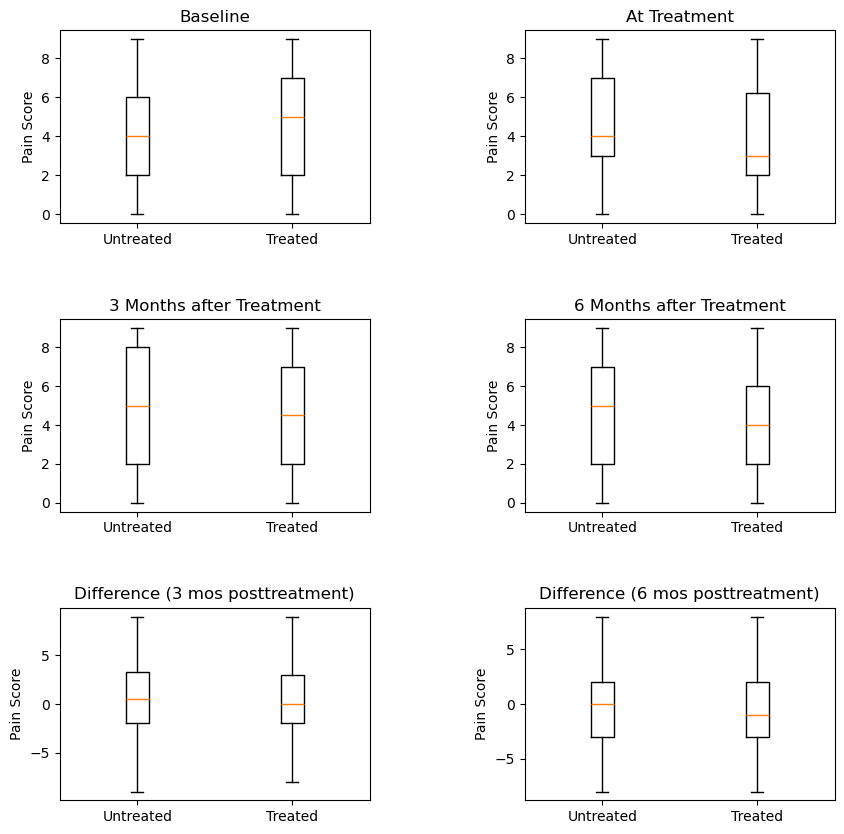

In [33]:
display_boxplots('pain', 'Pain Score')

### **URGENCY RESULTS:**

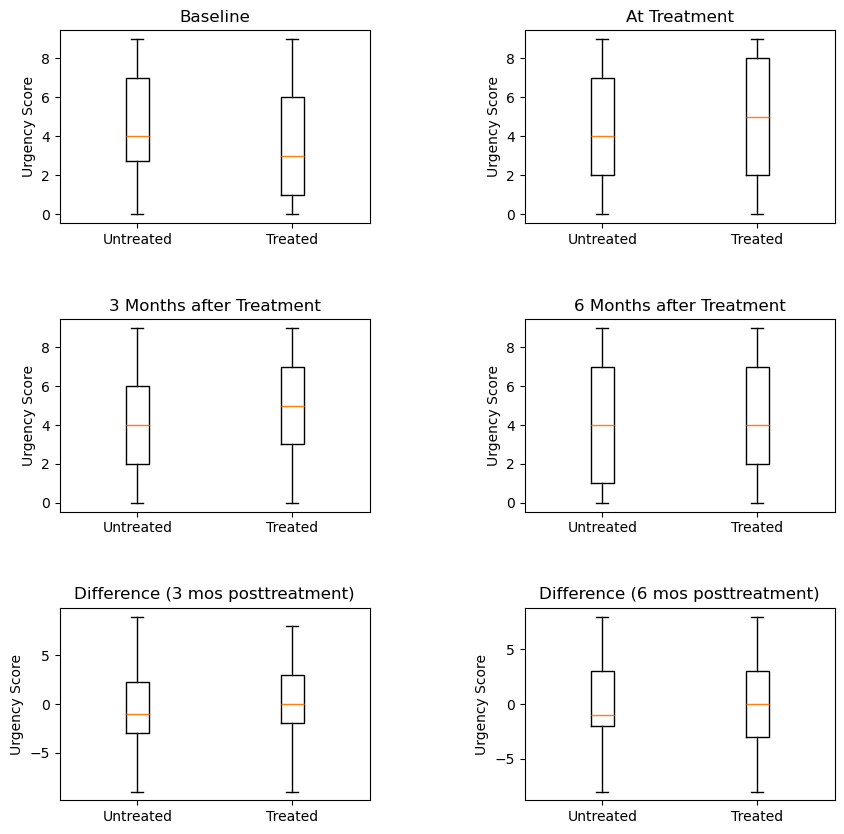

In [34]:
display_boxplots('urgency', 'Urgency Score')